## Ensemble useing linear Regression and Xgboost

In [1]:
import numpy as np
import pandas as pd
import os
print(os.listdir("../predict_future_sales/input/"))

['sales_train.csv', 'Untitled.ipynb', 'shops.csv', 'test.csv', 'item_categories.csv', 'items.csv', 'sample_submission.csv']


In [2]:
DATA_FOLDER = '../predict_future_sales/input'

transactions = pd.read_csv('input/sales_train.csv')
items = pd.read_csv('input/items.csv')
item_categories = pd.read_csv('input/item_categories.csv')
shops = pd.read_csv(os.path.join(DATA_FOLDER,'shops.csv'))
test = pd.read_csv(os.path.join(DATA_FOLDER,'test.csv'))

In [3]:
train_data = pd.read_pickle('data.pkl')
test_data = pd.read_pickle('test_data.pkl')

In [4]:
train_data.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,city_name,city_frequency,type,subtype,product_sales_lag_1,...,price_shop_cat_lag_6,item_cnt_month_per_type_lag_6,item_price_per_type_lag_6,item_cnt_day_city_lag_6,item_price_city_lag_6,item_cnt_day_city_cat_lag_6,item_price_city_cat_lag_6,item_cnt_month_lag_6,month,days
4836056,27,15242,13,2.0,63,13,0.216667,14,43,699.0,...,549.242004,0.266098,95.968460,0.483414,129.972885,0.517054,144.963425,1.0,1,28
4836057,27,15200,13,1.0,69,13,0.216667,14,58,0.0,...,364.789459,0.266098,95.968460,0.483414,129.972885,0.442857,105.851715,0.0,1,28
4836058,27,15279,13,2.0,63,13,0.216667,14,43,1598.0,...,380.922211,0.000000,47.450130,0.000000,112.183441,0.000000,47.114483,0.0,1,28
4836059,27,15202,13,1.0,69,13,0.216667,14,58,0.0,...,364.789459,0.266098,95.968460,0.483414,129.972885,0.442857,105.851715,0.0,1,28
4836060,27,14888,13,1.0,55,13,0.216667,13,4,1098.0,...,284.811615,0.199080,45.319733,0.483414,129.972885,0.386102,65.062836,1.0,1,28


In [5]:
test_data.head(5)

,shop_id,item_id,date_block_num,item_category_id,city_name,city_frequency,type,subtype,product_sales_lag_1,item_price_per_item_lag_1,...,price_shop_cat_lag_6,item_cnt_month_per_type_lag_6,item_price_per_type_lag_6,item_cnt_day_city_lag_6,item_price_city_lag_6,item_cnt_day_city_cat_lag_6,item_price_city_cat_lag_6,item_cnt_month_lag_6,month,days
0,5,5037,34,19,3,0.016667,5,12,0.0,1499.00000,...,1316.797974,0.487498,429.576782,0.180011,103.231186,0.432749,294.928619,1.0,10,30
1,5,5320,34,55,3,0.016667,13,4,NaN,449.00000,...,419.697266,0.000000,48.404102,0.000000,123.917900,0.000000,55.836678,0.0,10,30
2,5,5233,34,19,3,0.016667,5,12,1199.0,1199.00000,...,1316.797974,0.487498,429.576782,0.180011,103.231186,0.432749,294.928619,3.0,10,30
3,5,5232,34,23,3,0.016667,5,18,0.0,1190.43335,...,419.697266,0.000000,48.404102,0.000000,123.917900,0.000000,55.836678,0.0,10,30
4,5,5268,34,20,3,0.016667,5,13,NaN,449.00000,...,419.697266,0.000000,48.404102,0.000000,123.917900,0.000000,55.836678,0.0,10,30


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6077748 entries, 4836056 to 10913803
Columns: 123 entries, shop_id to days
dtypes: float32(114), int32(8), int8(1)
memory usage: 2.8 GB


In [7]:
from sklearn import preprocessing

In [8]:
lr_whole_data = pd.concat([train_data.drop('item_cnt_month',axis=1), test_data],sort=False)

lr_whole_data.shape

(6291948, 122)

In [9]:
category_feat_drop = ['days','type','city_name','month']
cat_feat = ['date_block_num','shop_id']
whole_date = lr_whole_data.date_block_num #Train/Testスライシングするために取得しておく
lr_whole_data = lr_whole_data.drop(category_feat_drop, axis=1)
lr_whole_data['date_block_num'] = lr_whole_data['date_block_num'].astype('str')#get_dummiesをdate_block_numにも適用させるため

In [10]:
for feat in lr_whole_data.columns:
    lr_whole_data[feat] = lr_whole_data[feat].fillna(lr_whole_data[feat].median())

In [11]:
for feat in cat_feat:
    lr_whole_data[feat] = pd.get_dummies(lr_whole_data[feat], sparse=False)

In [12]:
scaler = preprocessing.StandardScaler()

lr_whole_data = scaler.fit_transform(lr_whole_data)

In [13]:
y_train = train_data['item_cnt_month']
X_train_xgb = train_data.iloc[:, train_data.columns != 'item_cnt_month']


In [14]:
X_train_lr = lr_whole_data[whole_date != 34]
X_test_lr = lr_whole_data[whole_date == 34]

In [15]:
del lr_whole_data

In [16]:
X_train_lr.shape[0]

6077748

In [17]:
X_test_lr.shape[0]

214200

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
type(y_train)

pandas.core.series.Series

In [20]:
y_train.shape

(6077748,)

In [21]:
lr = LinearRegression()

In [22]:
#lr.fit(X_train_lr,y_train.values)

In [23]:
pred_lr = pd.read_csv('lr_submission.csv')
pred_xgb = pd.read_csv('early_stop_xgb_type_new.csv')

In [24]:
#pd.Series(pred_lr).describe()

In [25]:
# sub_df = pd.DataFrame({'ID':test.index,'item_cnt_month':pred_lr})
# sub_df.to_csv('lr_submission.csv',index=False)

In [26]:
pred_lr = pred_lr.item_cnt_month.values
pred_xgb = pred_xgb.item_cnt_month.values

In [27]:
X_test_level2 = np.c_[pred_lr, pred_xgb]

In [28]:
dates_train = X_train_xgb.date_block_num

In [29]:
dates_train_level2 = dates_train[dates_train.isin([31,32,33])]
#meta特徴量を作成するサンプルをmaskするため

y_train_level2 = y_train[dates_train.isin([31,32,33])]

In [30]:
from sklearn.linear_model import LinearRegression
import xgboost as xgb

In [31]:
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])
params = {
          'max_depth':10,
          'subsample':0.8,
          'min_child_weight':300,
          'colsample_bytree':0.8,
          'eta':0.3,'num_round':100,
          'seed':1,
          'silent':0,
          'eval_metric':'rmse'
         }

for cur_block_num in [31,32,33]:
    print(cur_block_num)
    X_train_beta_xgb = X_train_xgb[dates_train < cur_block_num]
    y_train_beta = y_train[dates_train < cur_block_num]
    X_train_beta_lr = X_train_lr[dates_train <cur_block_num]
    X_test_beta_lr = X_train_lr[dates_train == cur_block_num]
    X_test_beta_xgb = X_train_xgb[dates_train == cur_block_num]
    lr = LinearRegression()
    lr.fit(X_train_beta_lr, y_train_beta.values)
    pred_lr = lr.predict(X_test_beta_lr)
    xgbtrain = xgb.DMatrix(X_train_beta_xgb.values, y_train_beta.values)
    bst = xgb.train(params, xgbtrain, num_boost_round=9)
    xgbpredict = xgb.DMatrix(X_test_beta_xgb.values)
    pred_xgb = bst.predict(xgbpredict)
    X_train_level2[dates_train_level2 == cur_block_num, 0] = pred_lr
    X_train_level2[dates_train_level2 == cur_block_num, 1] = pred_xgb
   

31
[12:28:09] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
32
[12:43:47] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
33
[13:34:24] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [32]:
lr = LinearRegression()

diff = X_train_level2[:,0] - X_train_level2[:,1]

X_train_level2 = np.c_[X_train_level2, diff]

lr.fit(X_train_level2, y_train_level2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
diff = X_test_level2[:,0] - X_test_level2[:,1]
X_test_level2 = np.c_[X_test_level2,diff]
final_pred = lr.predict(X_test_level2)
final_pred = final_pred.clip(0,20)

In [34]:
sub_df = pd.DataFrame({'ID':test.index,'item_cnt_month':final_pred})

In [35]:
sub_df.to_csv('Lr_xgb_ensemble.csv',index=False)

In [36]:
pd.Series(final_pred).describe()

count    214200.000000
mean          0.301657
std           0.788175
min           0.000000
25%           0.017788
50%           0.105407
75%           0.304971
max          20.000000
dtype: float64

## LBとPrivateともにスコアは0.94

In [37]:
df_train  = pd.DataFrame(data = X_train_level2, columns = ['pred_lr','pred_xgb','diff'],dtype=float)
df_test = pd.DataFrame(data = X_test_level2, columns = ['pred_lr','pred_xgb','diff'],dtype=float)

### XGBoostをメタモデルとして採用する。

In [38]:
xgbtrain = xgb.DMatrix(df_train.values, y_train_level2.values)
bst = xgb.train(params, xgbtrain, num_boost_round=10)
xgbpredict = xgb.DMatrix(df_test.values)
pred = bst.predict(xgbpredict)

pred = pred.clip(0,20)
sub_df = pd.DataFrame({'ID':test.index,'item_cnt_month':pred})
sub_df.to_csv('Lr_xgb_ensemble_xgb.csv',index=False)
pd.Series(pred).describe()

count    214200.000000
mean          0.306532
std           0.785918
min           0.000000
25%           0.033961
50%           0.123864
75%           0.298930
max          16.350483
dtype: float64

## 過学習をしている。スコアはLBが0.95, Privateが0.95

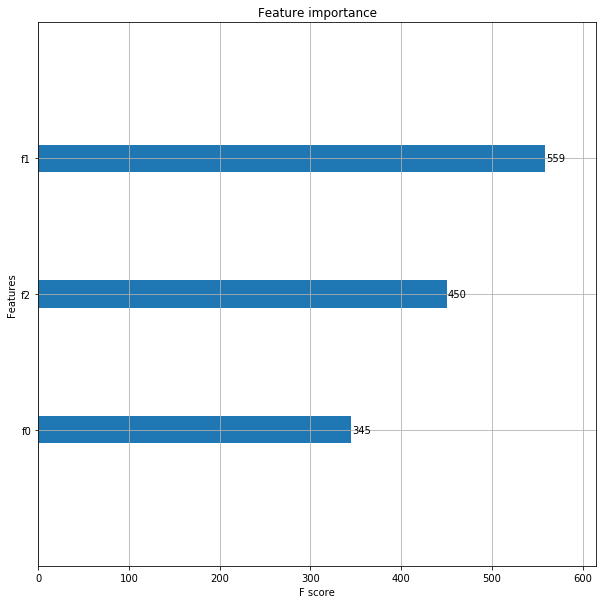

In [41]:
x = xgb.plot_importance(bst)
x.figure.set_size_inches(10, 10)

In [40]:
cols = list(df_train.columns)

[cols[x] for x in [0,1,2]]

['pred_lr', 'pred_xgb', 'diff']